In [ ]:
# Download the modules from requirements.txt, in case of error, run as pip rather than pip3
!pip3 install -r requirements.txt

In [1]:
#  Import modules
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [6]:
# Define the file path
file_path = 'aggregated_sentiment_analysis.csv'

# Load the entire dataset
df = pd.read_csv(file_path)

# Define the cities of interest
cities = ['new-york-city', 'san-francisco', 'austin', 'boston', 'barcelona', 'nashville', 
          'milan', 'munich', 'istanbul', 'london', 'riga', 'hong-kong', 'bangkok', 
          'singapore', 'melbourne', 'mexico-city', 'rio-de-janeiro', 'belize', 
          'santiago', 'toronto']

# Process the DataFrame for each city
for city in cities:
    # Filter the DataFrame for the current city
    # Ensure case-insensitive matching and strip potential leading/trailing whitespaces
    city_data = df[df['city'].str.contains(city, case=False, na=False)].copy()
    city_data['city'] = city_data['city'].str.strip()

    if not city_data.empty:
        # Split city data by room type
        for room_type in city_data['room_type'].unique():
            room_data = city_data[city_data['room_type'] == room_type]
            
            # Define the directory path based on city and room type
            # Replace '/' in room_type with '-' to avoid path issues
            directory_path = f"./{city}/{room_type.replace('/', '-')}"
            os.makedirs(directory_path, exist_ok=True)  # Create the directory if it doesn't exist
            
            # Define the file name and save the DataFrame to CSV
            file_name = f"{directory_path}/{city}_{room_type.replace('/', '-')}.csv"
            room_data.to_csv(file_name, index=False)

KeyboardInterrupt: 

In [72]:
def process_and_forecast(city, room_type):
    plot_dir = f"./plotted_graph/{city}"
    os.makedirs(plot_dir, exist_ok=True)
    
    file_path = f"./data/{city}/{room_type.replace('/', '-')}/{city}_{room_type.replace('/', '-')}.csv"
        
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        return
        
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    
    # Filter data up to the specified date for training
    #train_cutoff = pd.to_datetime('2020-03-01')
    #train_df = df[df.index <= train_cutoff]
    train_cutoff = pd.to_datetime('2022-06-01')
    train_df = df[df.index < train_cutoff]
    
    # Prepare the training DataFrame for Prophet
    train_df_for_prophet = train_df.reset_index()[['date', 'compound']].rename(columns={'date': 'ds', 'compound': 'y'})

    model = Prophet()
    model.fit(train_df_for_prophet)

    # Extend original data frame for future predictions beyond the training period
    last_date = df.index.max()
    future = model.make_future_dataframe(periods=(last_date - train_cutoff).days, freq='D')
    forecast = model.predict(future)

    # Plotting
    plt.figure(figsize=(12, 8))
    actual_monthly_avg = df[['compound']].resample('M').mean()
    forecast_monthly_avg = forecast.set_index('ds').resample('M').mean()['yhat']

    plt.plot(actual_monthly_avg.index, actual_monthly_avg['compound'], label="Actual", marker='o', color='blue')
    plt.plot(forecast_monthly_avg.index, forecast_monthly_avg, label="Forecast", linestyle='--', color='red')
    #plt.title(f"{room_type} Sentiment Analysis for {city.capitalize()}")
    plt.title(f"{room_type} Post-Covid Sentiment Analysis for {city.capitalize()}")
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()

    #plt.savefig(f"{plot_dir}/{city}_{room_type.replace('/', '-')}_sentiment_analysis.png")
    plt.savefig(f"{plot_dir}/{city}_{room_type.replace('/', '-')}_postCovid_sentiment_analysis.png")
    plt.close()

In [75]:
import matplotlib.dates as mdates

def process_and_forecast_combined(city, room_type):
    plot_dir = f"./plotted_graph/{city}"
    os.makedirs(plot_dir, exist_ok=True)
    
    file_path = f"./data/{city}/{room_type.replace('/', '-')}/{city}_{room_type.replace('/', '-')}.csv"
        
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        return
        
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    
    # Define the two training periods
    periods = [(pd.to_datetime('2016-01-01'), pd.to_datetime('2020-03-01')),
               (pd.to_datetime('2022-05-01'), pd.to_datetime('2023-03-01'))]
    
    forecasts = []
    for start, end in periods:
        train_df = df[(df.index >= start) & (df.index < end)]
        
        # Prepare the training DataFrame for Prophet
        train_df_for_prophet = train_df.reset_index()[['date', 'compound']].rename(columns={'date': 'ds', 'compound': 'y'})

        model = Prophet()
        model.fit(train_df_for_prophet)
        
        # Extend original data frame for future predictions within each training period
        future = model.make_future_dataframe(periods=(df.index.max() - start).days, freq='D')
        forecast = model.predict(future)
        forecasts.append(forecast)
    
    # Combine forecasts and plot
    plt.figure(figsize=(12, 8))
    actual_data = df[['compound']].resample('M').mean()

    # Plot actual data
    plt.plot(actual_data.index, actual_data['compound'], label="Actual", marker='o', color='blue')
    
    # Plot forecasts
    for forecast in forecasts:
        forecast_monthly_avg = forecast.set_index('ds')[['yhat']].resample('M').mean()
        plt.plot(forecast_monthly_avg.index, forecast_monthly_avg['yhat'], linestyle='--')

    plt.title(f"{room_type} Before- and Post- Covid Sentiment Analysis for {city.capitalize()}")
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Set x-axis to display years from 2016 to 2024
    plt.xlim([pd.to_datetime('2016-01-01'), pd.to_datetime('2024-01-01')])
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    
    plt.savefig(f"{plot_dir}/{city}_{room_type.replace('/', '-')}_before_post_covid_sentiment_analysis.png")
    plt.close()


In [76]:
cities = ['new-york-city','san-francisco','austin','boston','nashville',
          'toronto','barcelona','milan','munich','istanbul',
          'london','riga','hong-kong','bangkok','singapore',
          'melbourne','mexico-city','rio-de-janeiro','belize','santiago']
room_types = ['Entire home-apt', 'Private room', 'Shared room']
for city in cities:
    for room_type in room_types:
        process_and_forecast_combined(city, room_type)

21:48:21 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing
21:48:52 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1] done processing
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:32 - cmdstanpy - INFO - Chain [1] done processing
21:49:36 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:47 - cmdstanpy - INFO - Chain [1] start processing
21:49:47 - cmdstanpy - INFO - Chain [1] done processing
21:49:54 - cmdstanpy - INFO - Chain [1] start processing
21:50:00 - cmdstanpy - INFO - Chain [1] done processing
21:50:02 - cmdstanpy - INFO - Chain [1] start processing
21:50:04 - cmdstanpy - INFO - Chain [1] done processing
21:50:09 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1]

In [77]:
def plot_city_room_type_sentiments(aggregate_data, cities, room_types): 
    sns.set_style("whitegrid")

    # Calculate the total number of plots
    num_plots = len(cities)
    
    # Define the size of each subplot (width, height)
    subplot_width = 10
    subplot_height = 5
    
    # Define the overall figure size
    figure_width = subplot_width * min(num_plots, 5)  # Up to 5 plots per row
    figure_height = subplot_height * np.ceil(num_plots / 5).astype(int)  # Number of rows needed
    
    # Create a figure to hold the subplots with the overall size
    fig, axs = plt.subplots(int(np.ceil(num_plots / 5)), 5, figsize=(figure_width, figure_height))
    
    # Flatten the axes array for easy iteration and hide unused subplots if necessary
    axs = axs.flatten() if num_plots > 1 else [axs]
    for ax in axs[num_plots:]:
        ax.set_visible(False)
    
    # Plot each city's sentiment scores in a subplot
    for i, city in enumerate(cities):
        ax = axs[i]
        
        for room_type in room_types:
            df = aggregate_data[(aggregate_data['city'] == city) & (aggregate_data['room_type'] == room_type)]
            if df.empty:
                continue
            
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            monthly_avg = df['compound'].resample('M').mean()
            
            ax.plot(monthly_avg.index, monthly_avg, label=room_type, marker='o', linestyle='--', linewidth=2, markersize=8)
        
        ax.set_title(f"Monthly Average Sentiment for {city}")
        ax.set_xlabel('Date')
        ax.set_ylabel('Average Sentiment Score')
        ax.legend()
        ax.tick_params(axis='x', rotation=45, labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    plt.show()

In [79]:
aggregate_data = pd.read_csv('aggregated_sentiment_analysis.csv')

C:\Temp\ipykernel_20592\289328267.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Temp\ipykernel_20592\289328267.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Temp\ipykernel_20592\289328267.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

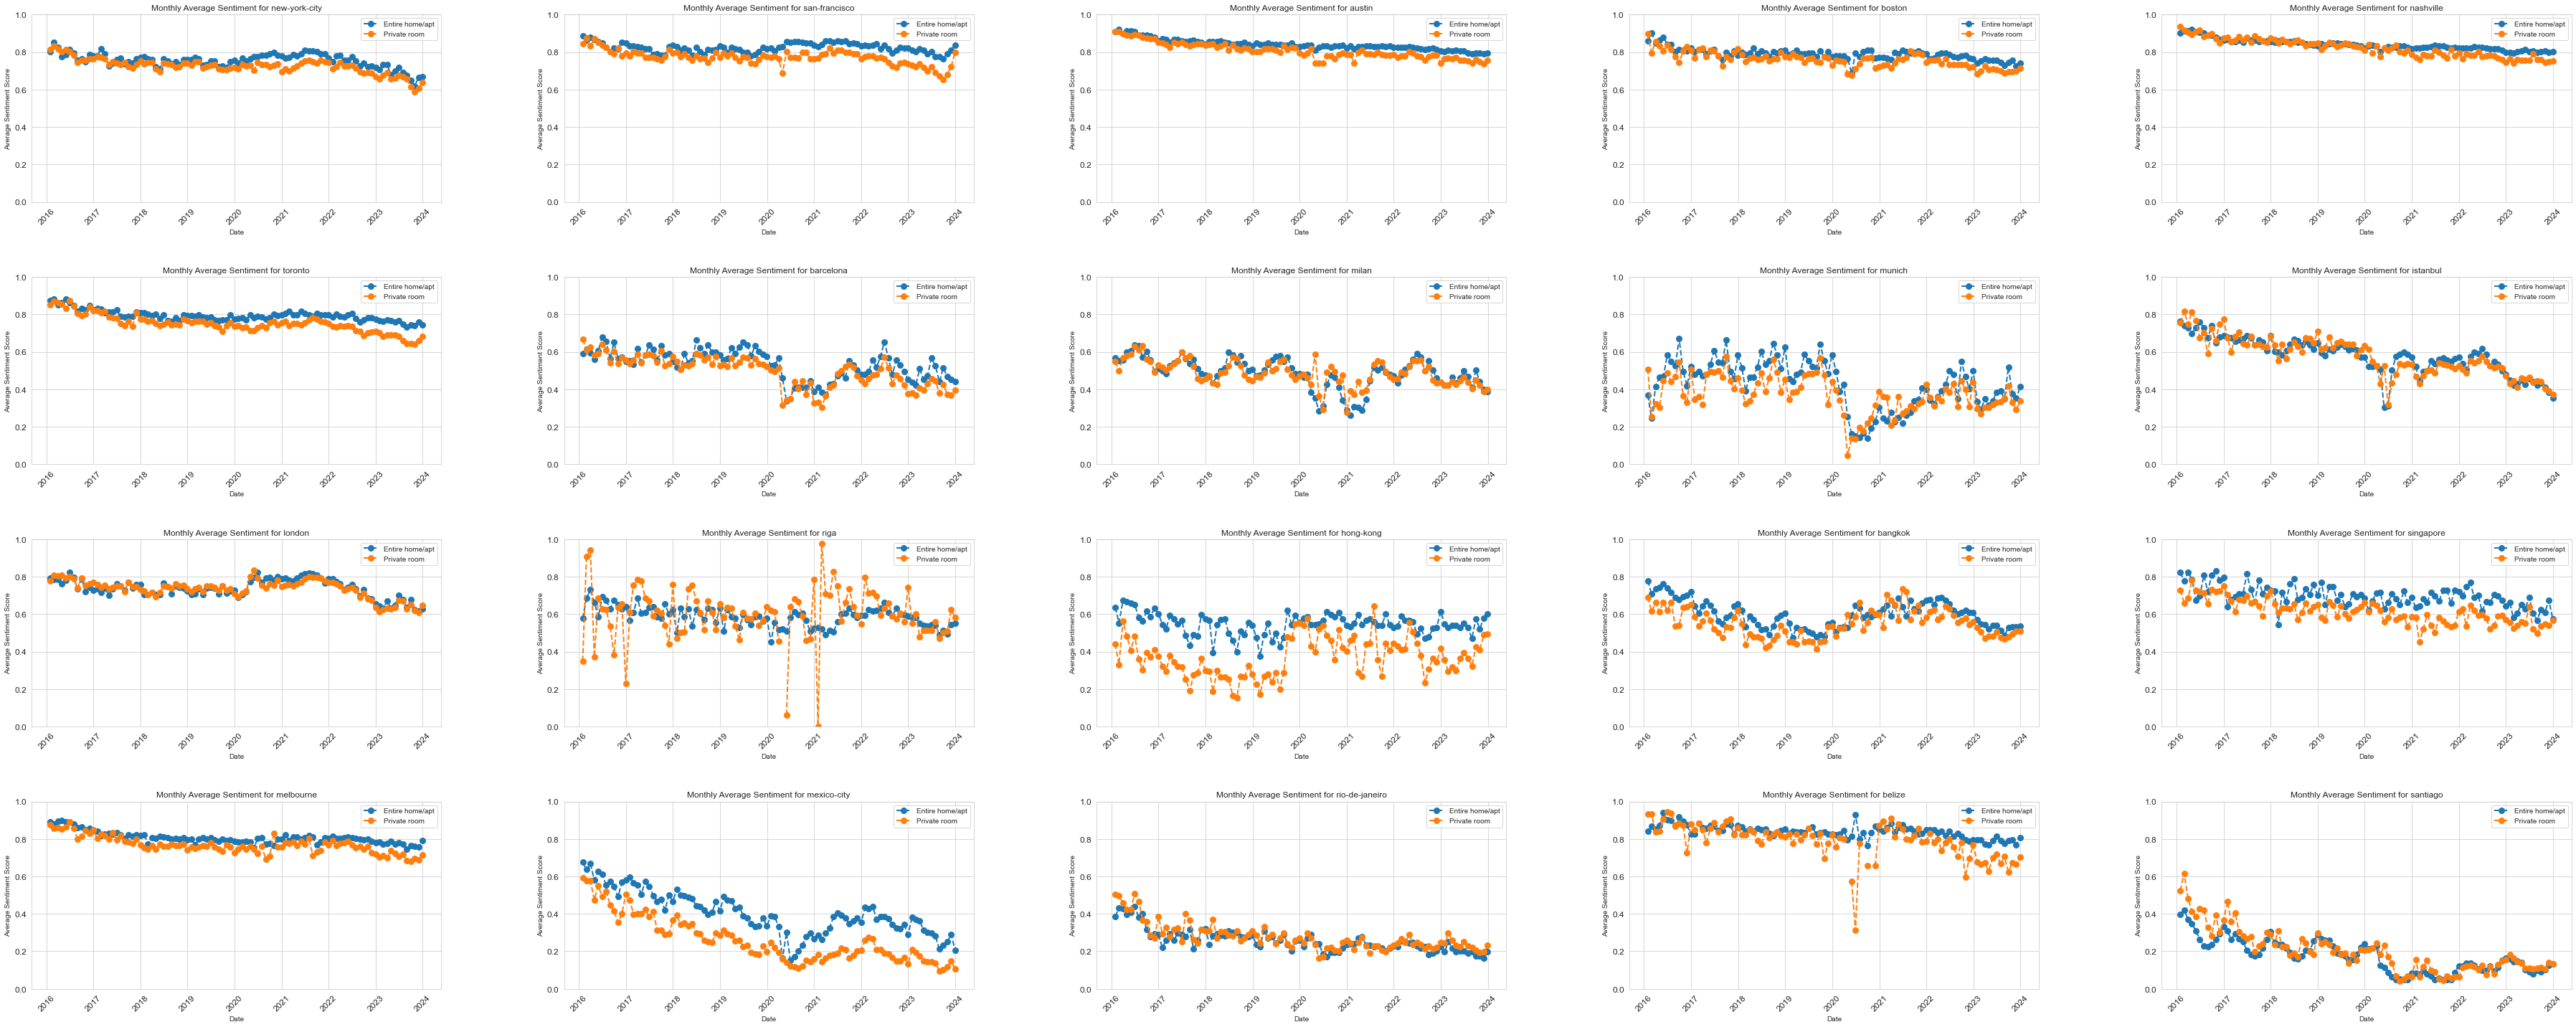

In [82]:
cities = ['new-york-city','san-francisco','austin','boston','nashville',
          'toronto','barcelona','milan','munich','istanbul',
          'london','riga','hong-kong','bangkok','singapore',
          'melbourne','mexico-city','rio-de-janeiro','belize','santiago']
room_types = ['Entire home/apt', 'Private room']
plot_city_room_type_sentiments(aggregate_data, cities, room_types)

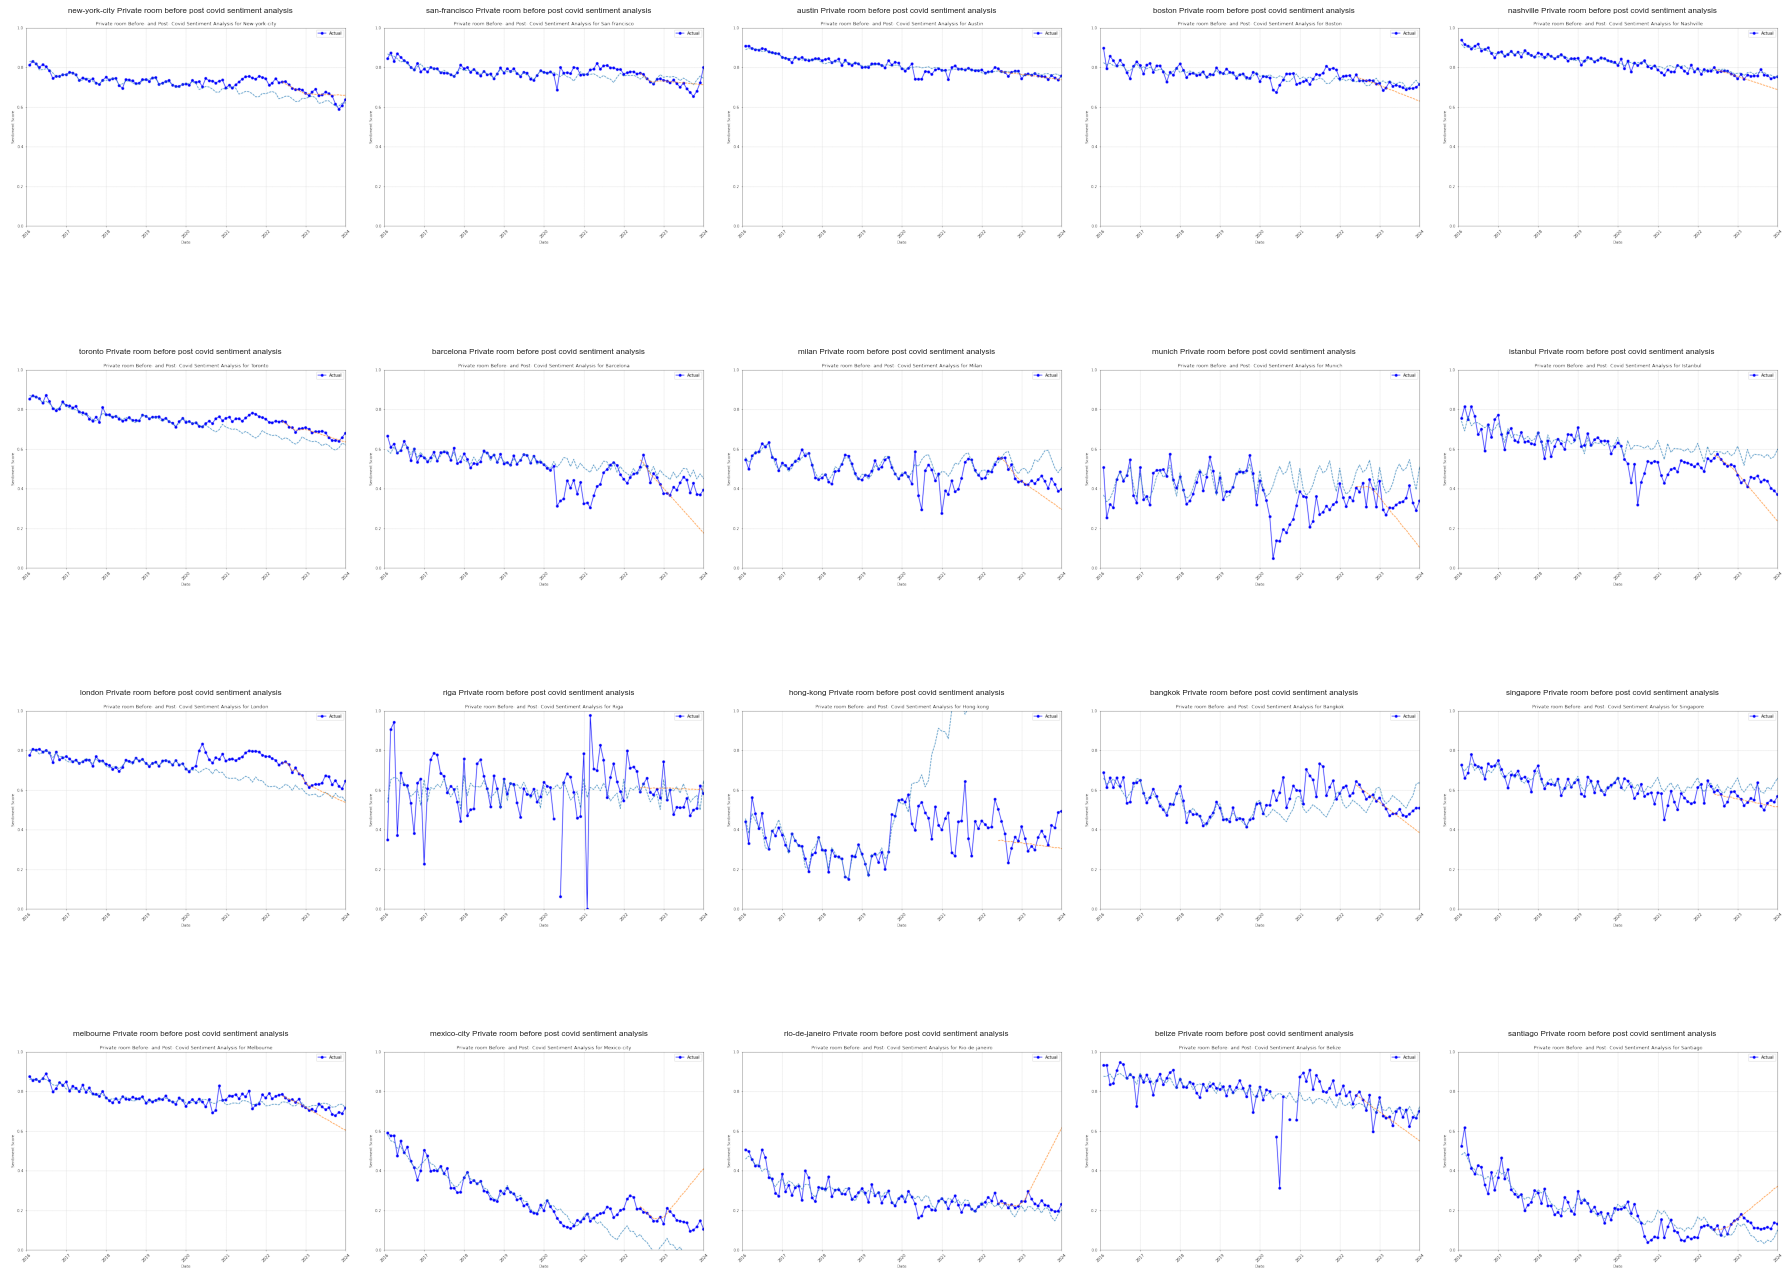

In [92]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_saved_graphs(cities, room_types, base_plot_dir="./plotted_graph", images_per_row=5):
    # Create a list to hold all the paths of the images to display
    image_paths = []

    # Construct the file paths for each city and room type
    for city in cities:
        for room_type in room_types:
            # Construct the filename based on the given pattern
            image_name = f"{city}_{room_type.replace('/', '-')}_before_post_covid_sentiment_analysis.png"
            image_path = os.path.join(base_plot_dir, city, image_name)
            if os.path.exists(image_path):
                image_paths.append(image_path)
            else:
                print(f"Image not found: {image_path}")

    # Calculate the number of rows needed
    num_rows = len(image_paths) // images_per_row + (len(image_paths) % images_per_row > 0)
    
    # Plot each image in a grid layout
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 5, num_rows * 5))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, ax in enumerate(axes):
        ax.axis('off')  # Hide axes
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.set_title(os.path.basename(image_paths[i]).replace('_', ' ').replace('.png', ''), fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Example usage:
cities = ['new-york-city', 'san-francisco', 'austin', 'boston', 'nashville',
          'toronto', 'barcelona', 'milan', 'munich', 'istanbul',
          'london', 'riga', 'hong-kong', 'bangkok', 'singapore',
          'melbourne', 'mexico-city', 'rio-de-janeiro', 'belize', 'santiago']

room_types = ['Private room']

# Display the saved plots
display_saved_graphs(cities, room_types)



In [5]:
aggregate_data = pd.read_csv('aggregated_sentiment_analysis.csv')

In [1]:
covid_start = '2020-02-01'
covid_end = '2022-07-01'
pre_covid_df = aggregate_data[aggregate_data['date'] < covid_start]
post_covid_df = aggregate_data[aggregate_data['date'] >= covid_end]

pre_covid_scores = pre_covid_df.groupby(['city', 'room_type'])['compound'].mean().reset_index(name='pre_covid_score')
post_covid_scores = post_covid_df.groupby(['city', 'room_type'])['compound'].mean().reset_index(name='post_covid_score')

df = pre_covid_scores.merge(post_covid_scores, on=['city', 'room_type'])


NameError: name 'aggregate_data' is not defined

In [42]:
df = df[~df['room_type'].isin(['Shared room', 'Hotel room'])]
display(df.head())

,city,room_type,pre_covid_score,post_covid_score,Percentage Difference
0,austin,Entire home/apt,0.852745,0.806251,-5.452231
2,austin,Private room,0.831824,0.761114,-8.500535
4,bangkok,Entire home/apt,0.563280,0.552090,-1.986576
6,bangkok,Private room,0.504942,0.511095,1.218431
8,barcelona,Entire home/apt,0.595687,0.500695,-15.946652


In [13]:
def calculate_percentage_difference(df):
    df['Percentage Difference'] = ((df['post_covid_score'] - df['pre_covid_score']) / df['pre_covid_score']) * 100
    return df

In [46]:
def plot_diverging_bar_chart(df, title_suffix=''):
    df = df.sort_values('Percentage Difference')
    plt.figure(figsize=(10, 8))
    plt.barh(df['city'], df['Percentage Difference'], color=df['Percentage Difference'].apply(lambda x: 'green' if x > 0 else 'red'))
    plt.axvline(x=0, color='grey', lw=1.5, linestyle='--')
    plt.xlabel('Percentage Difference (%)')
    plt.title(f'Percentage Difference in Sentiment Scores Before and After Covid. {title_suffix}')
    plt.xlim(-50, 30)
    plt.grid(axis='x')
    plt.show()

In [38]:
def plot_for_room_types(df):
    room_types = df['room_type'].unique()
    
    # Plot for each room type
    for room_type in room_types:
        df_filtered = df[df['room_type'] == room_type]
        if not df_filtered.empty:
            plot_diverging_bar_chart(calculate_percentage_difference(df_filtered), room_type)
    
    # Plot combined, ignoring room type
    plot_diverging_bar_chart(calculate_percentage_difference(df.copy()), 'Cumulative')


C:\Temp\ipykernel_17156\3812731144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Percentage Difference'] = ((df['post_covid_score'] - df['pre_covid_score']) / df['pre_covid_score']) * 100


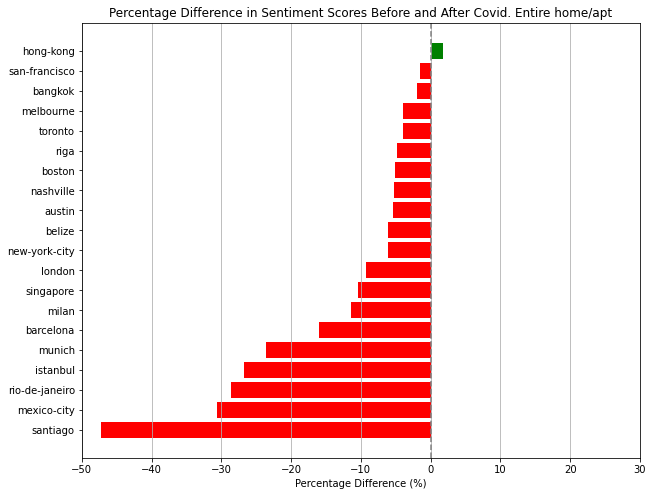

C:\Temp\ipykernel_17156\3812731144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Percentage Difference'] = ((df['post_covid_score'] - df['pre_covid_score']) / df['pre_covid_score']) * 100


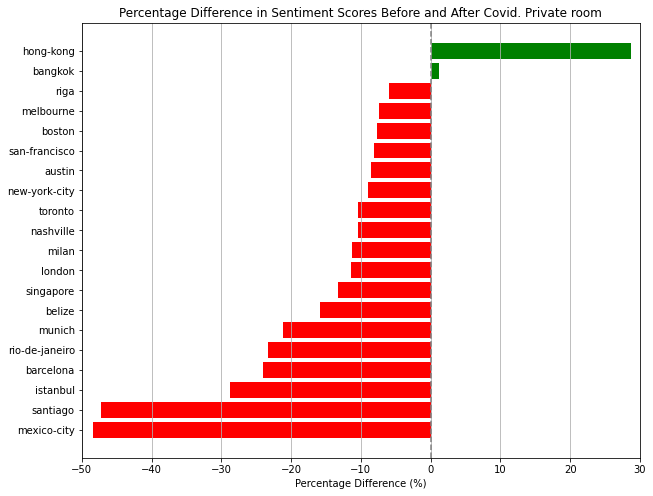

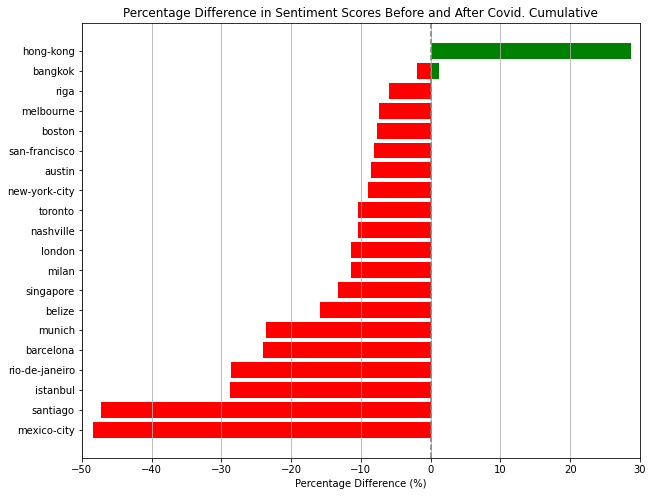

In [47]:
plot_for_room_types(df)

C:\Temp\ipykernel_17156\2215794441.py:46: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='grey', hatch='/', alpha=0.5, label='Entire home/apt', edgecolor='black'),
C:\Temp\ipykernel_17156\2215794441.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='grey', label='Private Room', edgecolor='black'),


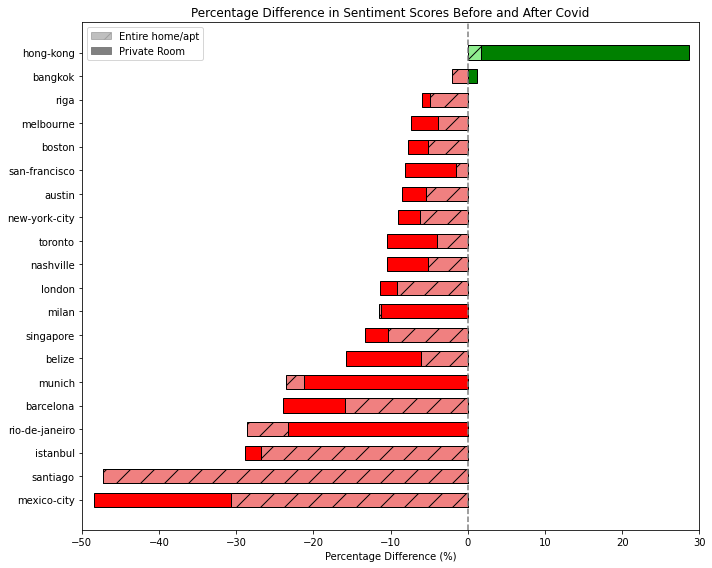

In [195]:
df_cumulative_sorted = df.sort_values('Percentage Difference')

def plot_combined_room_types(df):
    plt.figure(figsize=(10, 8))
    
    df['Abs Percentage Difference'] = df['Percentage Difference'].abs()

    # Get unique cities for ordering
    cities = df['city'].unique()

    # Initialize a dictionary to track y positions for cities
    city_positions = {city: idx for idx, city in enumerate(cities)}

    # Iterate through each city to plot
    for city in cities:
        city_df = df[df['city'] == city]

        # Sort room types within each city by absolute change to ensure the desired layering
        sorted_city_df = city_df.sort_values(by='Abs Percentage Difference', ascending=False)

        for _, row in sorted_city_df.iterrows():
            room_type = row['room_type']
            percentage_diff = row['Percentage Difference']
            position = city_positions[city]

            # Determine color and pattern based on room type and percentage difference
            if percentage_diff > 0:
                color = 'lightgreen' if room_type == 'Entire home/apt' else 'green'
            else:
                color = 'lightcoral' if room_type == 'Entire home/apt' else 'red'
            hatch = '/' if room_type == 'Entire home/apt' else None
            alpha = 1.0  # Keep full opacity for both

            # Plot
            plt.barh(position, percentage_diff, color=color, edgecolor='black', 
                     hatch=hatch, height=0.6, alpha=alpha)

    plt.axvline(x=0, color='grey', lw=1.5, linestyle='--')
    plt.xlabel('Percentage Difference (%)')
    plt.title('Percentage Difference in Sentiment Scores Before and After Covid')
    plt.yticks(np.arange(len(cities)), cities)
    plt.xlim(-50, 30)
    
    # Update the custom legend to reflect the new differentiation strategy
    custom_patches = [
        plt.Rectangle((0,0),1,1, color='grey', hatch='/', alpha=0.5, label='Entire home/apt', edgecolor='black'),
        plt.Rectangle((0,0),1,1, color='grey', label='Private Room', edgecolor='black'),
    ]
    plt.legend(handles=custom_patches, loc='best')
    plt.tight_layout()
    plt.show()

plot_combined_room_types(df_cumulative_sorted)


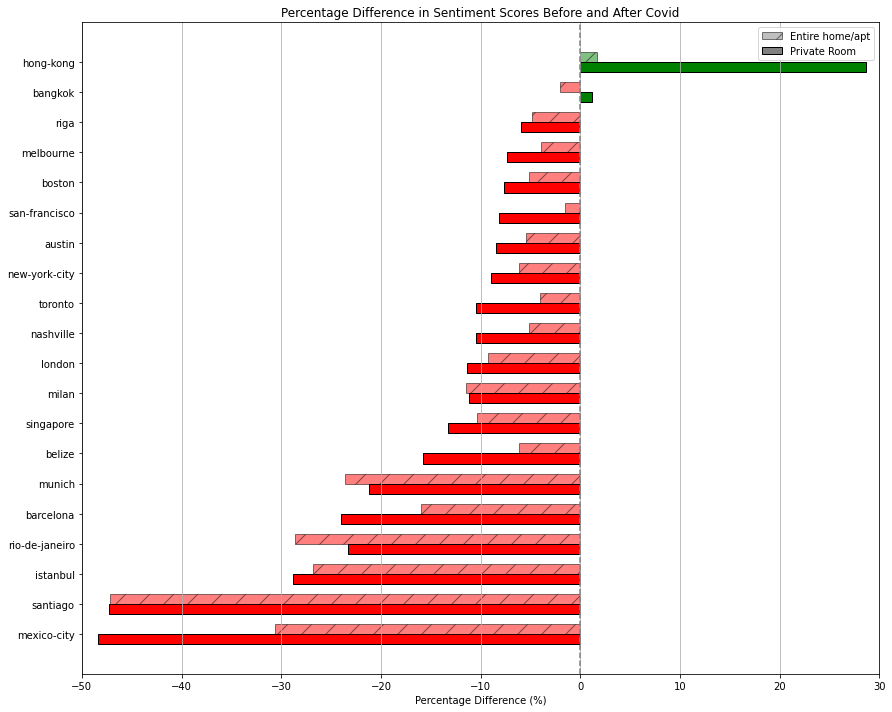

In [193]:
import matplotlib.patches as mpatches

def plot_combined_room_types(df_sorted):
    plt.figure(figsize=(12.5, 10))

    y_positions = {}
    current_position = 0

    def get_color(value):
        return 'green' if value > 0 else 'red'
    
    for index, row in df_sorted.iterrows():
        city = row['city']
        room_type = row['room_type']
        percentage_diff = row['Percentage Difference']
        
        if city not in y_positions:
            y_positions[city] = current_position
            current_position += 3

        position_offset = 0.5 if room_type == 'Entire home/apt' else -0.5
        position = y_positions[city] + position_offset

        alpha_val = 0.5 if room_type == 'Entire home/apt' else 1.0
        hatch_pattern = '/' if room_type == 'Entire home/apt' else None

        plt.barh(position, percentage_diff, color=get_color(percentage_diff), 
                 edgecolor='black', height=1, alpha=alpha_val, hatch=hatch_pattern)

    plt.axvline(x=0, color='grey', lw=1.5, linestyle='--')
    plt.xlabel('Percentage Difference (%)')
    plt.title('Percentage Difference in Sentiment Scores Before and After Covid')
    plt.yticks([pos for pos in y_positions.values()], [city for city in y_positions.keys()])
    plt.xlim(-50, 30)
    entire_home_patch = mpatches.Patch(facecolor='grey', edgecolor='black', label='Entire home/apt', alpha=0.5, hatch='/')
    private_room_patch = mpatches.Patch(facecolor='grey', edgecolor='black', label='Private Room', alpha=1.0)
    plt.legend(handles=[entire_home_patch, private_room_patch], loc='best')
    
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

plot_combined_room_types(df_cumulative_sorted)
